In [24]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install matplotlib numpy sympy scipy h5py
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import scipy.ndimage as nd
import h5py as hdf

# H1
f = hdf.File('data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', "r")
print(list(f.keys()))
dset = f['strain']['Strain']
print(dset.attrs.keys())
XStart = dset.attrs.get("Xstart")
dX = dset.attrs.get("Xspacing")
N = dset.attrs.get("Npoints")

['meta', 'quality', 'strain']
<KeysViewHDF5 ['Npoints', 'Xlabel', 'Xspacing', 'Xstart', 'Xunits', 'Ylabel', 'Yunits']>


The anomaly starts at GPS Time 1126259462, so find the n so that the resulting subdataset does not contain it

Maximum n value:  61440  out of  131072


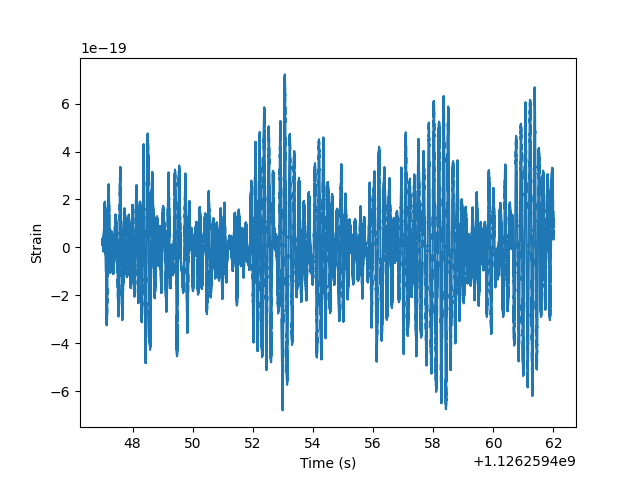

In [27]:
anomaly_time = 1126259462
max_n = int((anomaly_time - XStart) // dX)
print("Maximum n value: ", max_n, " out of ", N)
xValues = XStart + dX * np.arange(max_n)
yValues = dset[:max_n]
plt.figure()
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.plot(xValues, yValues)

Periodogram spectrum smoothing


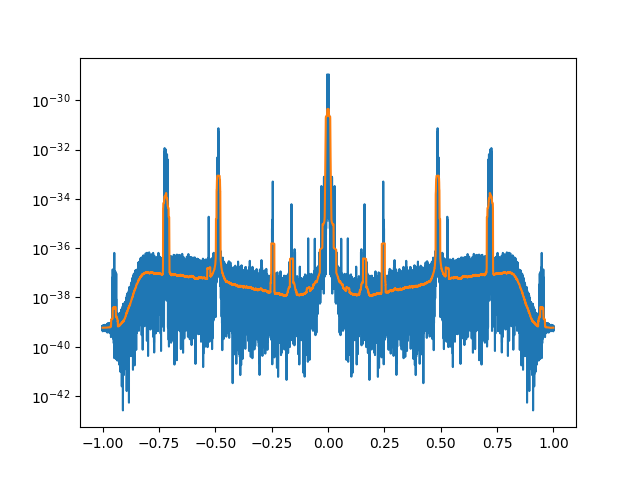

In [31]:
plt.close()

# The recommended L range goes from 0.1N to 0.2N see Manolakis
# Lfactor = 0.1 # maximum Lag (length of the smoothing window) as a factor of N
Lfactor = 0.007
N = max_n
f = np.linspace(-1, 1, N)
M = int(N*Lfactor) # Smoothing window length
y = yValues
H = np.zeros(N) # Smoothing window
start = (N-M)//2
H[start:start+M] = 1/M
h = np.fft.fft(H)
Y = np.fft.fft(y)
R_y = Y * np.conj(Y)

r_y = np.fft.ifft(R_y)
r_y_PS = r_y * h
R_y_PS = np.fft.fft(r_y_PS)
plt.figure()
plt.semilogy(f, np.fft.fftshift(np.abs(R_y)),
             f, np.abs(R_y_PS))

Periodogram Averaging

c:\Users\Marco\OneDrive\Desktop\Python\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Marco\OneDrive\Desktop\Python\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


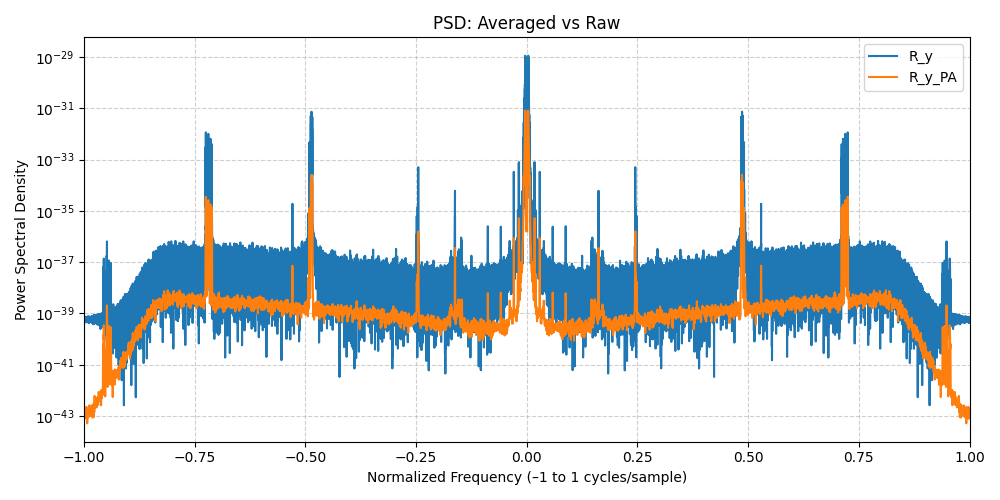

In [57]:
################################## manual implementation of Welch's method ##################################
plt.close()
N = max_n # data length
K = 10 # Number of segments
overlap_ratio = 0.5 # Segment overlap ratio
L = int(N // K) # Segment length
window = np.hanning(L) # Window function for each segment
L = int(N // K) # Segment length
D = int(L * overlap_ratio) # Segment overlap
y = yValues
segments = []

# segmenting the signal and calculating periodograms:
for k in range(K):
    segment = y[k*(L-D):k*(L-D)+L] * window
    Y = np.fft.fft(segment)
    segments.append(Y * np.conj(Y))

# average the periodograms
segments = np.array(segments)
R_y_PA = np.mean(segments, axis=0)

# create plot wit smoothed periodogram and the original periodo
f = np.fft.fftfreq(L, d=1.0)      # range: [-0.5, 0.5)
f = np.fft.fftshift(f)            # shift to [-0.5, 0.5]
R_y_PA = np.fft.fftshift(R_y_PA)  # align PSD with frequencies

# Compute raw (unsmoothed) PSD from entire signal
Y = np.fft.fft(y)
R_y = Y * np.conj(Y)
R_y = np.fft.fftshift(R_y)

# Frequency axis for raw PSD (same as before)
f_y = np.fft.fftshift(np.fft.fftfreq(N, d=1.0))
f_raw = f_y * 2  # scale from -1 to 1

# Plot both PSDs
plt.figure(figsize=(10, 5))

plt.semilogy(f_raw, R_y, label='R_y')
plt.semilogy(f * 2, R_y_PA, label='R_y_PA')

plt.xlabel("Normalized Frequency (–1 to 1 cycles/sample)")
plt.ylabel("Power Spectral Density")
plt.title("PSD: Averaged vs Raw")
plt.xlim(-1, 1)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()






